In [1]:
import sys
import numpy as np # linear algebra
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
sys.path.append('/repos/keras_preprocessing/keras_preprocessing')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation ,Dense, Flatten ,BatchNormalization ,MaxPooling2D ,Conv2D
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import preprocess_input
import itertools
from tensorflow.keras.layers import Dropout

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import InceptionResNetV2
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore' , category=FutureWarning)
%matplotlib inline

In [2]:
con_base=tf.keras.applications.mobilenet.MobileNet()
#con_base= InceptionResNetV2(weights='imagenet',include_top=False , input_shape=(224,224,3))

17227776/17225924 [==============================] - 0s 0us/step


In [3]:
x=con_base.layers[-6].output
output=Dense(units=200,activation='softmax')(x)
model=tf.keras.Model(inputs=con_base.input,outputs=output)

In [4]:
for layer in model.layers[:-23]:
    layer.trainable=False

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [6]:
train_path='../input/image-detect/train'
test_path='../input/image-detect/test'
validation_path='../input/image-detect/val'


In [7]:
labels= pd.read_csv('../input/image-detect/wnids.txt')
val_anno=pd.read_csv('../input/image-detect/val/val_annotations.txt', sep='\t',header=None,names=['Files','labels','X','Y','H','W'])
val_anno.drop(['X','Y','H','W'] , axis=1, inplace=True)
#val_anno.names=['file','classes']
val_anno.head()


,Files,labels
0,val_0.JPEG,n07753592
1,val_1.JPEG,n02883205
2,val_2.JPEG,n04532670
3,val_3.JPEG,n03160309
4,val_4.JPEG,n07583066


In [8]:
training_data=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest').flow_from_directory(directory=train_path,target_size=(224,224),batch_size=64)
testing_data=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),batch_size=64 ,shuffle=False)


Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 1 classes.


In [9]:
datagen=ImageDataGenerator(rescale=1./255.)
validation_data=datagen.flow_from_dataframe(
dataframe=val_anno,
directory="../input/image-detect/val/images",
x_col="Files",
y_col="labels",
batch_size=64,
class_mode="categorical",
classes=['n02124075','n04067472','n04540053','n04099969','n07749582','n01641577','n02802426','n09246464','n07920052','n03970156','n03891332','n02106662',
'n03201208','n02279972','n02132136','n04146614','n07873807','n02364673','n04507155','n03854065','n03838899','n03733131','n01443537','n07875152','n03544143',
'n09428293','n03085013','n02437312','n07614500','n03804744','n04265275','n02963159','n02486410','n01944390','n09256479','n02058221','n04275548','n02321529',
'n02769748','n02099712','n07695742','n02056570','n02281406','n01774750','n02509815','n03983396','n07753592','n04254777','n02233338','n04008634','n02823428',
'n02236044','n03393912','n07583066','n04074963','n01629819','n09332890','n02481823','n03902125','n03404251','n09193705','n03637318','n04456115',
'n02666196','n03796401','n02795169','n02123045','n01855672','n01882714','n02917067','n02988304','n04398044','n02843684','n02423022',
'n02669723','n04465501','n02165456','n03770439','n02099601','n04486054','n02950826','n03814639','n04259630','n03424325','n02948072',
'n03179701','n03400231','n02206856','n03160309','n01984695','n03977966','n03584254','n04023962','n02814860','n01910747','n04596742',
'n03992509','n04133789','n03937543','n02927161','n01945685','n02395406','n02125311','n03126707','n04532106','n02268443','n02977058',
'n07734744','n03599486','n04562935','n03014705','n04251144','n04356056','n02190166','n03670208','n02002724','n02074367','n04285008',
'n04560804','n04366367','n02403003','n07615774','n04501370','n03026506','n02906734','n01770393','n04597913','n03930313','n04118538',
'n04179913','n04311004','n02123394','n04070727','n02793495','n02730930','n02094433','n04371430','n04328186','n03649909','n04417672',
'n03388043','n01774384','n02837789','n07579787','n04399382','n02791270','n03089624','n02814533','n04149813','n07747607','n03355925',
'n01983481','n04487081','n03250847','n03255030','n02892201','n02883205','n03100240','n02415577','n02480495','n01698640','n01784675',
'n04376876','n03444034','n01917289','n01950731','n03042490','n07711569','n04532670','n03763968','n07768694','n02999410','n03617480',
'n06596364','n01768244','n02410509','n03976657','n01742172','n03980874','n02808440','n02226429','n02231487','n02085620','n01644900',
'n02129165','n02699494','n03837869','n02815834','n07720875','n02788148','n02909870','n03706229','n07871810','n03447447','n02113799',
'n12267677','n03662601','n02841315','n07715103','n02504458'
         
],
target_size=(224,224))

Found 10000 validated image filenames belonging to 200 classes.


In [10]:
imgs,lab= next(validation_data)


In [11]:
def plotimages(images_arr):
    fig , axes=plt.subplots(1 ,10 ,figsize=(20,20))
    axes= axes.flatten()
    for img ,ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


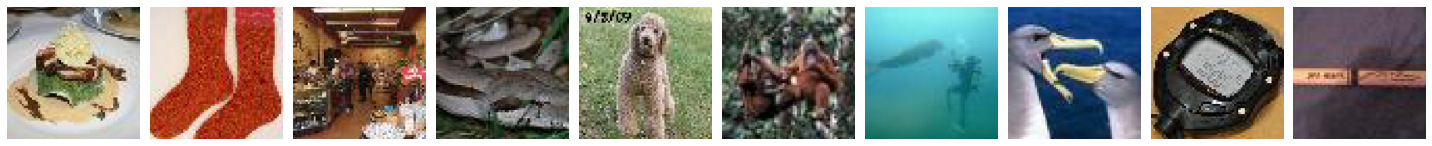

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
plotimages(imgs)
print(lab)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy' ,metrics=['accuracy'] )


In [14]:
model.fit(x=training_data,validation_data=validation_data,epochs=10,verbose=2)

Epoch 1/10
1407/1407 - 1217s - loss: 3.4145 - accuracy: 0.2691 - val_loss: 2.2894 - val_accuracy: 0.4471
Epoch 2/10
1407/1407 - 1091s - loss: 2.4147 - accuracy: 0.4351 - val_loss: 1.9881 - val_accuracy: 0.5134
Epoch 3/10
1407/1407 - 1088s - loss: 2.1354 - accuracy: 0.4896 - val_loss: 1.8219 - val_accuracy: 0.5509
Epoch 4/10
1407/1407 - 1137s - loss: 1.9751 - accuracy: 0.5214 - val_loss: 1.7459 - val_accuracy: 0.5655
Epoch 5/10
1407/1407 - 1174s - loss: 1.8585 - accuracy: 0.5456 - val_loss: 1.7369 - val_accuracy: 0.5722
Epoch 6/10
1407/1407 - 1173s - loss: 1.7569 - accuracy: 0.5680 - val_loss: 1.6777 - val_accuracy: 0.5843
Epoch 7/10
1407/1407 - 1151s - loss: 1.6891 - accuracy: 0.5822 - val_loss: 1.6544 - val_accuracy: 0.5937
Epoch 8/10
1407/1407 - 1173s - loss: 1.6164 - accuracy: 0.5955 - val_loss: 1.6170 - val_accuracy: 0.5999
Epoch 9/10
1407/1407 - 1168s - loss: 1.5594 - accuracy: 0.6079 - val_loss: 1.6155 - val_accuracy: 0.6005
Epoch 10/10
1407/1407 - 1180s - loss: 1.5087 - accuracy

In [15]:
predict = model.predict(testing_data)


In [16]:
predicted_indices=np.argmax(predict,axis=1)


In [17]:
label_map = dict((v,k) for k,v in training_data.class_indices.items())
pred=[label_map[k] for k in predicted_indices ]


In [18]:
import os
test_filenames = os.listdir("../input/image-detect/test/images")
test_df = pd.DataFrame({
    'file_name': test_filenames,'category':pred
    
})

In [19]:
#test_df['category'] = predict
test_df.head()

,file_name,category
0,test_8436.JPEG,n03444034
1,test_2671.JPEG,n02231487
2,test_827.JPEG,n09428293
3,test_213.JPEG,n04597913
4,test_7434.JPEG,n02056570


In [20]:
test_df.to_csv('submission.csv', index=False)
